In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#@author: Kelle Clark, Andrew Florian, Xinyu Xiong
#Created on Tue Feb  4 10:05:49 2020
#CSCI 6040 Project 1 Text Generation
#PHASE 3: Smoothing the Language Models for the Corpus

#Various folders of .txt files were created in the CSCI6040 Team Project 1 folder
#to be used for testing our application during develpment
#/Short Test Data
# has 3 .txt files each about 4KB
#/Med test Data 
# has 2 .txt files one of 119KB (Tragedy of Macbeth) and 6.5MB (big)
#/Grande test Data (the 18-document-gutenburg-copus but with 19? files cleaned using the 
#boilerplate.ipynb -author Andrew Florian and resulting files 
#shared on Canvas in Project 1 discussion forum)
# has 19 .txt files with a total of 11.8MB

In [68]:
#we needed the help of a few packages...import all those at once
import langid
import itertools 
import nltk
import numpy
import os
import pandas
import random
import re
import string
import sys
from collections import Counter
from math import log10
from matplotlib.pyplot import yscale, xscale, title, plot
from nltk.tokenize import word_tokenize, sent_tokenize

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM
#from keras.utils import np_utils
#from keras.callbacks import ModelCheckpoint


In [69]:
#**** from phase 1 reading in the tokenized corpus

def tokensByFiles(folderpath):
    textfiles = [f for f in os.listdir(folderpath) if '.txt' in f]
    tokenfilelist =[]
    
    for f in textfiles:
            rawcorpus = []
            substring = ''
            file = open(folderpath+"/"+f,'rt', encoding='utf-8', errors='replace')                                   
            print (f"     Reading from: '{f}' . . .")
            rawcorpus.append(file.read()
                     .replace('. . .','.')
                     .replace('!',' .')  # substitue space period for ! mark to have a simple token to end a sentence 
                     .replace('"',' ')
                     .replace('#',' ')  
                     .replace('$',' ')
                     .replace('%',' ')
                     .replace('&',' ')
                     .replace('\\',' ') 
                     .replace('\' ',' ')  # only remove ' if it has a space before or after meaning it is used as a quote
                     .replace(' \'',' ')  # but leave it in if it is inside a word as a contraction
                     .replace('\- ',' ')  # only remove - if it has a space before or after meaning it is to be left in the 
                     .replace(' \-',' ')  # word e.g. C-A-T
                     .replace('(',' ')
                     .replace('\n', ' ')        
                     .replace(')',' ')
                     .replace('*',' ')
                     .replace('+',' ')
                     .replace(',',' ')
                     .replace('. ',' ')  
                     .replace('/',' ')                 
                     .replace(':',' ')
                     .replace(';',' ')
                     .replace('<',' ')
                     .replace('=',' ')
                     .replace('>',' ')
                     .replace('?',' .')  # substitue space period for ? mark to have a simple token to end a sentence
                     .replace('@',' ')
                     .replace('[',' ')
                     .replace('\\',' ')
                     .replace(']',' ')
                     .replace('^',' ')
                     .replace('_',' ')   #  remove all unwanted punctuation
                     .replace('`',' ')
                     .replace('{',' ')
                     .replace('|',' ')
                     .replace('}',' ')
                     .replace('~',' ')
                     .replace('0',' ')   #  remove all digits
                     .replace('1',' ')
                     .replace('2',' ')
                     .replace('3',' ')
                     .replace('4',' ')
                     .replace('5',' ')                
                     .replace('6',' ')
                     .replace('7',' ')
                     .replace('8',' ')
                     .replace('9',' '))            
            file.close()
            
            substring = substring + rawcorpus[0]
            #print(f"the language of file "+f+" is {nltk.language(substring)}")
            print(f"the estimated language of the file {f} is {langid.classify(substring)}")
            
            #tokens=substring.split()
            tokens = word_tokenize(substring)
            tokens = [w.lower() for w in tokens]
            tokenfilelist.append(tokens)
             
    return tokenfilelist


#we have the different files tokenized, in the variable tokenfilelist
#method below creates one corpus from the string of tokens in each file 
def createOneCorpus(inlist):
    temp = " "
    for i in range(len(inlist)):
        for w in inlist[i]:
            temp = temp + w + " "
    return temp

def printcorpus(instring):
    if len(instring) > 500: 
        print(f"The first & last 50 tokens of this corpus are:\n  {instring[:50]} \t ... {instring[-50:]}\n")
    else:
        print(f"The tokens in the corpus are: \n {instring} \n")

#ngrams returns a dictionary
# enumerate ngrams code copied from Eisentein and CSCI6040 ipynb
# returns the ngram from instring and n
def ngrams(instring, n):
    outset = {}
    for i in range(len(instring) - n + 1):
        g = ' '.join(instring[i:i+n])
        outset.setdefault(g, 0)
        outset[g] += 1
    return outset        


In [70]:
#**** from phase 1 reading in the .txt files and creating the tokenized corpus
pathname = 'Test Data/short test data'
#pathname = 'your choice of path here'

#read in the corups file by file
tokenfilelist = tokensByFiles(pathname)
#print(tokenfilelist)

tokencorpus = createOneCorpus(tokenfilelist)
#printcorpus(tokencorpus)
tokens = tokencorpus.split()

     Reading from: 'Testset1.txt' . . .
the estimated language of the file Testset1.txt is ('en', -112.47618627548218)
     Reading from: 'Testset2.txt' . . .
the estimated language of the file Testset2.txt is ('en', -757.8414204120636)
     Reading from: 'Testset3.txt' . . .
the estimated language of the file Testset3.txt is ('en', -295.17291164398193)


The sum of all the probabiities of unigrams needs to be 1 and it is 1.0000000000000009

Number of rows in Unigram Prob. Model :  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
the unigram of greatest freq is: do 

The sum of all the probabiities for bigrams needs to be 1 and it is 0.9894736842105274
Number of rows in Bigram Prob. Model :  87
               prob.
the cat     0.010526
cat named   0.010526
named bob   0.010526
bob is      0.021053
is damn     0.010526
...              ...
not exist   0.010526
exist on    0.010526
earth dogs  0.010526
dogs are    0.010526
are the     0.010526

[87 rows x 1 columns]
the bigram of greatest freq  is: are the 

The sum of all the probabiities for trigrams needs to be 1 and it is 0.9789473684210537
Number of rows in Trigram Prob. Model :  91
                   prob

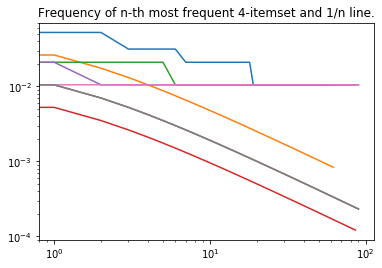

In [71]:
#**** from phase 2 creating the four different language models using ngrams:
#unigram prob. model using prob(x) = (frequency of x in corpus)/(total in corpus)
def createUnigramModel(instring):
    n = 1
    outset = word_tokenize(instring)

    totalpossible = len(outset)
    sumofprob = 0
    
    anoutcome = ngrams(outset,n)
    probmodel = anoutcome
  
    for keyword in anoutcome:
        probmodel[keyword] = (anoutcome[keyword]) / totalpossible
        sumofprob = sumofprob + probmodel[keyword]
    
    print(f"The sum of all the probabiities of unigrams needs to be 1 and it is {sumofprob}\n")
    return probmodel
 
#create the unigram model 
unigrammodel = createUnigramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
unidataframe = pandas.DataFrame.from_dict(unigrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Unigram Prob. Model : ', len(unidataframe.index))
print(unidataframe)

#Attempt to try and plot the unigram language model using first a Counter object
COUNT = Counter(unigrammodel)
greatestprob = 0
bigword = ''
for w in COUNT.keys():
    if COUNT[w] >= greatestprob:
        bigword = w
        greatestprob = COUNT[w]
        
print(f"the unigram of greatest freq is: {bigword} \n")
M = COUNT[bigword]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##UNIGRAMS, WE COULD USE PROB. M/i for the ith rankend term and M is the frequency of the
##MOST COMMON UNIGRAM
plot([c for (w,c) in COUNT.most_common()])
plot([M/i for i in range(1, len(COUNT)+1)]);

#method to create the bigram model
def createBigramModel(instring):
    n = 2
    outset = word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,n)
    previousoutcome = ngrams(outset,n-1)
    sumofprob = 0
    
    probmodel = anoutcome
       
    for keyword in anoutcome:
        listword = keyword.split()
        prob1 = (previousoutcome[listword[0]]) / totalpossible
        probmodel[keyword] = prob1 * ((probmodel[keyword]) / (previousoutcome[listword[0]]))
        sumofprob = sumofprob + probmodel[keyword]
        
    print(f"The sum of all the probabiities for bigrams needs to be 1 and it is {sumofprob}")
    return probmodel  


#create the bigram model
bigrammodel = createBigramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
bidataframe = pandas.DataFrame.from_dict(bigrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Bigram Prob. Model : ', len(bidataframe.index))
print(bidataframe)

#Attempt to try and plot the bigram language model using first a Counter object
COUNT2 = Counter(bigrammodel)
greatestprob2 = 0
bigword2 = ''
for w in COUNT2.keys():
    if COUNT2[w] >= greatestprob2:
        bigword2 = w
        greatestprob2 = COUNT[w]
        
print(f"the bigram of greatest freq  is: {bigword2} \n")
M2 = COUNT2[bigword2]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 2-itemset and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##BIGRAMS, WE COULD USE PROB. M/i for the ith rankend term and M is the frequency of the
##MOST COMMON BIGRAM
plot([c for (w,c) in COUNT2.most_common()])
plot([(M2)/i for i in range(1, len(COUNT2)+1)]);


#create the trigram model
def createTrigramModel(instring):
    n = 3
    outset = word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,3)
    probmodel = anoutcome
    sumofprob = 0
    
    previous1outcome = ngrams(outset,n-2)
    previous2outcome = ngrams(outset,n-1)
    
    for keyword in anoutcome:    
        listword = keyword.split()
        wordofinterest = listword[0]
        prob1 = previous1outcome[wordofinterest]/ totalpossible
           
        wordofinterest = listword[0] + " " + listword[1]
        prob2 = previous2outcome[wordofinterest]/previous1outcome[listword[0]] 
           
        wordofinterest = keyword
        probmodel[keyword] = prob1 * prob2 * anoutcome[wordofinterest]/ previous2outcome[listword[0]+ " " + listword[1]]
        sumofprob = sumofprob + probmodel[keyword]
        
    print(f"The sum of all the probabiities for trigrams needs to be 1 and it is {sumofprob}")
    return probmodel  

#create the trigram model
trigrammodel = createTrigramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
tridataframe = pandas.DataFrame.from_dict(trigrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Trigram Prob. Model : ', len(tridataframe.index))
print(tridataframe)

#Attempt to plot the trigram language model using first a Counter object
COUNT3 = Counter(trigrammodel)
greatestprob3 = 0
bigword3 = ''
for w in COUNT3.keys():
    if COUNT3[w] >= greatestprob3:
        bigword3 = w
        greatestprob3 = COUNT3[w]
        
print(f"the trigram of greatest freq  is: {bigword3} \n")
M3 = COUNT3[bigword3]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 3-itemset and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##TRIGRAMS, WE COULD USE PROB. M3/i for the ith rankend term and M3 is the frequency of the
##MOST COMMON TRIGRAM
plot([c for (w,c) in COUNT3.most_common()])
plot([(M3)/i for i in range(1, len(COUNT3)+1)]);

#create the quadgram model
def createQuadgramModel(instring):
    n = 4
    outset = word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,n)
    probmodel = anoutcome   
    sumofprob = 0
   
    previous1outcome = ngrams(outset,n-3)
    previous2outcome = ngrams(outset,n-2)
    previous3outcome = ngrams(outset,n-1)
  
    for keyword in anoutcome:       
        listword = keyword.split()
        wordofinterest = listword[0]
        prob1 = previous1outcome[wordofinterest]/ totalpossible
           
        wordofinterest = listword[0] + " " + listword[1]
        prob2 = previous2outcome[wordofinterest]/previous1outcome[listword[0]] 
           
        wordofinterest = listword[0]+ " " + listword[1] + " " + listword[2]
        prob3 = previous3outcome[wordofinterest]/previous2outcome[listword[0] + " " + listword[1]]
           
        wordofinterest = keyword
        probmodel[keyword] = prob1 * prob2 * prob3 * anoutcome[wordofinterest]/ previous3outcome[listword[0]+ " " + listword[1] + " "+ listword[2]]
        sumofprob = sumofprob + probmodel[keyword]
           
    print(f"The sum of all the probabiities of quadgrams needs to be 1 and it is {sumofprob}")
    return probmodel  

#create the quadgram model
quadgrammodel = createQuadgramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
quaddataframe = pandas.DataFrame.from_dict(quadgrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Quadgram Prob. Model : ', len(quaddataframe.index))
print(quaddataframe)

#Attempt to plot the trigram language model using first a Counter object
COUNT4 = Counter(quadgrammodel)
greatestprob4 = 0
bigword4 = ''
for w in COUNT4.keys():
    if COUNT4[w] >= greatestprob4:
        bigword4 = w
        greatestprob4 = COUNT4[w]
        
print(f"the quadgram of greatest freq is: {bigword4} \n")
M4 = COUNT4[bigword4]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 4-itemset and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##QUADGRAMS, WE COULD USE PROB. M4/i for the ith rankend term and M3 is the frequency of the
##MOST COMMON TRIGRAM
plot([c for (w,c) in COUNT4.most_common()])
plot([(M4)/i for i in range(1, len(COUNT4)+1)]);

In [72]:
#The team kept both ngrams method and newngram method for computing the unigrams, bigrams, trigrams and quadgrams
#smoothed models....output of newngram is a Counter obj and output of ngrams is a dictionary object...

#newngram outputs to files:
#the most common unigrams are set to unigramfile-smaller.dat
#the most common bigrams are set to bigramfile-smaller.dat
#the most common trigrams are set to trigramfile-smaller.dat
#the most common quadgrams are set to quadgramfile-smaller.dat

#newngram returns a count object
def newngram(toks, n):
    output = {}   
    for i in range(len(toks) - n + 1):
        g = ' '.join(toks[i:i+n])
        output.setdefault(g, 0)
        output[g] += 1
    COUNTS = Counter(output)
    if n == 1:
        #print(f"\n   The most common unigrams are: {(COUNTS.most_common(10))}")
        f=open("unigramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(3000))) #trying to keep file size at about 50 k for this sample
        f.close()
    if n == 2:
        #print(f"\n   The most common bigrams are: {(COUNTS.most_common(10))}")
        f=open("bigramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2700))) #trying to keep file size at about 50 k for this sample
        f.close()
    if n == 3:
        #print(f"\n The most common trigrams are: {(COUNTS.most_common(10))}")
        f=open("trigramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2300))) #trying to keep file size at about 50 k for this sample
        f.close()
    if n == 4:
        #print(f"\n   The most common quadgrams are: {(COUNTS.most_common(10))}")
        f=open("quadgramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2100))) #trying to keep file size at about 50 k for this sample
        f.close()
    
    return COUNTS

newunigrams = newngram(tokens, 1)
#print(newunigrams)
newbigrams = newngram(tokens, 2)
#print(newbigrams)
newtrigrams = newngram(tokens, 3)
#print(newtrigrams)
newquadgrams = newngram(tokens, 4)
#print(newquadgrams)



In [74]:
#smoothing the ngramModel using a linear function of the kgrams for k = 1 to n
def ngramModel_LinearSmooth(inlist, n):
    #generate ngrams
    total = len(inlist)
    anoutcome = []
    for i in range(1,n+1):
        anoutcome.append(ngrams(inlist, i))
        #print("outcome: ")
        #print(anoutcome[i-1])
        
    #generate lamd coefficients for terms in model
    k = 1
    lamd = []
    last_lamd = 0
    for i in range(1,n):
        lamd.append(random.uniform(0,k))
        k = k-lamd[i -1]              
    lamd.append(k)
    print("lamd: ", lamd)
    #generate smooth model
    smooth_model = {}
    for keyword in anoutcome[n-1]:
        grams = keyword.split(' ')
        #print("grams:")
        #print(grams)
        smooth_model.setdefault(keyword, lamd[0]*anoutcome[0][grams[0]]/total)
        for i in range(1,len(grams) - 2):
            sub_string = ' '.join(grams[0:i])
            sub_sub_string = ' '.join(input[0:i -1])
           # print(sub_string)
            smooth_model[keyword] = smooth_model[keyword] + lamd[i] * (anoutcome[i][sub_string]/anoutcome[i-1][keyword])
        #print(keyword + ":")
        #print(smooth_model[keyword])
    #print("smooth_model:")
    #print(smooth_model)
    return smooth_model

lamd:  [1]
Number of rows in Linear Smoothed Unigram Prob. Model :  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
the unigram of greatest freq in the smoothed unigram model is: do 



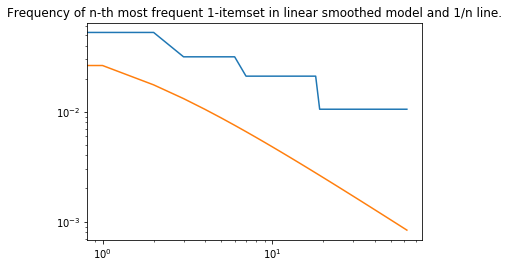

In [75]:
linearsmoothunimodel = ngramModel_LinearSmooth(tokens, 1)

pandas.set_option("display.max_rows", 10)
linearsmoothunidataframe = pandas.DataFrame.from_dict(linearsmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Unigram Prob. Model : ', len(linearsmoothunidataframe.index))
print(linearsmoothunidataframe)

#Attempt to plot the unigram language model using first a Counter object
COUNTLSMOOTH1 = Counter(linearsmoothunimodel)
greatestlinearsmoothprob1 = 0
biglinearsmoothword1 = ''
for w in COUNTLSMOOTH1.keys():
    if COUNTLSMOOTH1[w] >= greatestlinearsmoothprob1:
        biglinearsmoothword1 = w
        greatestlinearsmoothprob1 = COUNTLSMOOTH1[w]
        
print(f"the unigram of greatest freq in the smoothed unigram model is: {biglinearsmoothword1} \n")
MLS1 = COUNTLSMOOTH1[biglinearsmoothword1]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 1-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH1.most_common()])
plot([(MLS1)/i for i in range(1, len(COUNTLSMOOTH1)+1)]);

lamd:  [0.4268614788929469, 0.5731385211070531]
Number of rows in Linear Smoothed Bigram Prob. Model :  87
               prob.
the cat     0.022466
cat named   0.008987
named bob   0.004493
bob is      0.008987
is damn     0.022466
...              ...
not exist   0.004493
exist on    0.004493
earth dogs  0.008987
dogs are    0.004493
are the     0.008987

[87 rows x 1 columns]
the bigram of greatest freq in the linear smoothed bigram model is: is better 



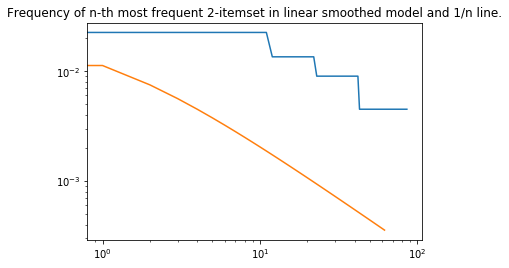

In [76]:
linearsmoothbimodel = ngramModel_LinearSmooth(tokens, 2)

pandas.set_option("display.max_rows", 10)
linearsmoothbidataframe = pandas.DataFrame.from_dict(linearsmoothbimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Bigram Prob. Model : ', len(linearsmoothbidataframe.index))
print(linearsmoothbidataframe)

#Attempt to plot the bigram language model using first a Counter object
COUNTLSMOOTH2 = Counter(linearsmoothbimodel)
greatestlinearsmoothprob2 = 0
biglinearsmoothword2 = ''
for w in COUNTLSMOOTH2.keys():
    if COUNTLSMOOTH2[w] >= greatestlinearsmoothprob2:
        biglinearsmoothword2 = w
        greatestlinearsmoothprob2 = COUNTLSMOOTH2[w]
        
print(f"the bigram of greatest freq in the linear smoothed bigram model is: {biglinearsmoothword2} \n")
MLS2 = COUNTLSMOOTH2[biglinearsmoothword2]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 2-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH2.most_common()])
plot([(MLS2)/i for i in range(1, len(COUNTLSMOOTH1)+1)]);

lamd:  [0.36168584557427774, 0.5096301016614089, 0.12868405276431338]
Number of rows in Linear Smoothed Trigram Prob. Model :  91
                   prob.
the cat named   0.019036
cat named bob   0.007614
named bob is    0.003807
bob is damn     0.007614
is damn good    0.019036
...                  ...
exist on earth  0.003807
on earth dogs   0.007614
earth dogs are  0.007614
dogs are the    0.003807
are the best    0.007614

[91 rows x 1 columns]
the trigram of greatest freq in the smoothed trigram model is: is better cats 



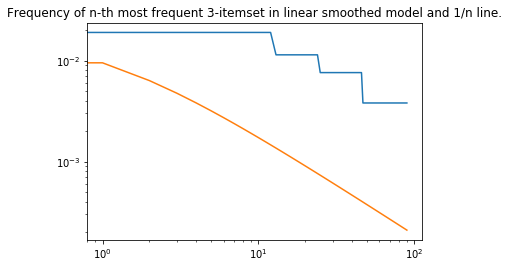

In [77]:
linearsmoothtrimodel = ngramModel_LinearSmooth(tokens, 3)

pandas.set_option("display.max_rows", 10)
linearsmoothtridataframe = pandas.DataFrame.from_dict(linearsmoothtrimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Trigram Prob. Model : ', len(linearsmoothtridataframe.index))
print(linearsmoothtridataframe)

#Attempt to plot the trigram language model using first a Counter object
COUNTLSMOOTH3 = Counter(linearsmoothtrimodel)
greatestlinearsmoothprob3 = 0
biglinearsmoothword3 = ''
for w in COUNTLSMOOTH3.keys():
    if COUNTLSMOOTH3[w] >= greatestlinearsmoothprob3:
        biglinearsmoothword3 = w
        greatestlinearsmoothprob3 = COUNTLSMOOTH3[w]
        
print(f"the trigram of greatest freq in the smoothed trigram model is: {biglinearsmoothword3} \n")
MLS3 = COUNTLSMOOTH3[biglinearsmoothword3]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 3-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH3.most_common()])
plot([(MLS3)/i for i in range(1, len(COUNTLSMOOTH3)+1)]);

In [78]:
linearsmoothquadmodel = ngramModel_LinearSmooth(tokens, 4)

pandas.set_option("display.max_rows", 10)
linearsmoothquaddf = pandas.DataFrame.from_dict(linearsmoothquadmodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Quadgram Prob. Model : ', len(linearsmoothquaddf.index))
print(linearsmoothquaddf)

#Attempt to plot the quadgram language model using first a Counter object
COUNTLSMOOTH4 = Counter(linearsmoothquadmodel)
greatestlinearsmoothprob4 = 0
biglinearsmoothword4 = ''
for w in COUNTLSMOOTH4.keys():
    if COUNTLSMOOTH4[w] >= greatestlinearsmoothprob4:
        biglinearsmoothword4 = w
        greatestlinearsmoothprob4 = COUNTLSMOOTH4[w]
        
print(f"the quadgram of greatest freq in the smoothed quadgram model is: {biglinearsmoothword4} \n")
MLS4 = COUNTLSMOOTH4[biglinearsmoothword4]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 4-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH4.most_common()])
plot([(MLS4)/i for i in range(1, len(COUNTLSMOOTH4)+1)]);

lamd:  [0.38784215461814153, 0.34917297585447465, 0.17260700717981442, 0.0903778623475694]


TypeError: 'method' object is not subscriptable

In [79]:
#In case we want to take into consideration of the file size when smoothing
#the language models... we created a Counter object for each file to seperate
#the unigrams, bigrams, trigrams and quadgrams in each file and their fruency in the file...
#the createListDoc_Foo_Counters below take in a list of strings, one fore each incoming file, which we
#created when we read in the files ....the smoothing in the Laplace smoothing below do not weight
#the files by size but do use these counters to tally up the total freqeuencies of ngrams and token count
def createListDocUniCounter(inlist):
    docfreqlist = []
    for i in range(len(inlist)):
        counter = Counter(newngram(inlist[i],1))
        docfreqlist.append(counter)
    return docfreqlist

dfforuniperfile = createListDocUniCounter(tokenfilelist)
firstunifile = dfforuniperfile[0]
#print(dfforuniperfile)
#print(firstunifile)

def createListDocBiCounter(inlist):
    df = []
    for i in range(len(inlist)):
        #words = re.findall("\w+",inlist[i])
        counter = Counter(newngram(inlist[i],2))
        df.append(counter)
    return df

dfforbiperfile = createListDocBiCounter(tokenfilelist)
firstbifile = dfforbiperfile[0]
#print(firstbifile)
#print(dfforbiperfile)

def createListDocTriCounter(inlist):
    df = []
    for i in range(len(inlist)):
        #words = re.findall("\w+",inlist[i])
        counter = Counter(newngram(inlist[i],3))
        df.append(counter)
    return df

dffortriperfile = createListDocTriCounter(tokenfilelist)
firsttrifile = dffortriperfile[0]
#print(firsttrifile)
#print(dffortriperfile)

def createListDocQuadCounter(inlist):
    df = []
    for i in range(len(inlist)):
        #words = re.findall("\w+",inlist[i])
        counter = Counter(newngram(inlist[i],4))
        df.append(counter)
    return df

dfforquadperfile = createListDocQuadCounter(tokenfilelist)
firstquadfile = dfforquadperfile[0]
#print(firstquadfile)
#print(dfforquadperfile)

In [102]:
#Laplace smoothed unigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedUnigramModel(outset, dfperfilelist):
    n = 1   
    anoutcome = ngrams(outset,n)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
       
        
    #print(f"The laplaceprobmodel is \n {laplaceprobmodel}")
    print(f"The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    

The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is 0.9999999999999991
Number of rows in Laplace Smoothed Unigram Prob. Model :  63
           prob.
the     0.028169
cat     0.017606
named   0.014085
bob     0.017606
is      0.028169
...          ...
cats    0.014085
should  0.014085
not     0.014085
exist   0.014085
dogs    0.014085

[63 rows x 1 columns]
the unigram of greatest freq in the Laplace smoothed unigram model is: is 



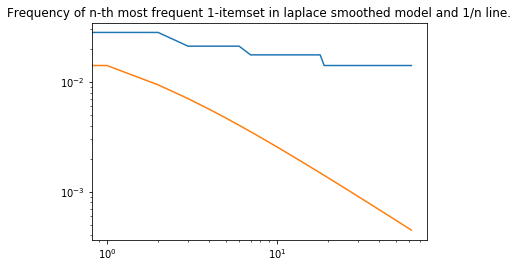

In [103]:
laplacesmoothunimodel = createLeplaceSmoothedUnigramModel(tokens, dfforuniperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothunidf = pandas.DataFrame.from_dict(laplacesmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Unigram Prob. Model : ', len(laplacesmoothunidf.index))
print(laplacesmoothunidf)

#Attempt to plot the unigram language model using first a Counter object
COUNTLapSMOOTH1 = Counter(laplacesmoothunimodel)
greatestlaplacesmoothprob1 = 0
biglaplacesmoothword1 = ''
for w in COUNTLapSMOOTH1.keys():
    if COUNTLapSMOOTH1[w] >= greatestlaplacesmoothprob1:
        biglaplacesmoothword1 = w
        greatestlaplacesmoothprob1 = COUNTLapSMOOTH1[w]
        
print(f"the unigram of greatest freq in the Laplace smoothed unigram model is: {biglaplacesmoothword1} \n")
MLapS1 = COUNTLapSMOOTH1[biglaplacesmoothword1]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 1-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH1.most_common()])
plot([(MLapS1)/i for i in range(1, len(COUNTLapSMOOTH1)+1)]);

In [104]:
#Laplace smoothed bigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedBigramModel(outset, dfperfilelist):
    n = 2    
    anoutcome = ngrams(outset,n)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            #print(keyword, count[keyword], filecount)
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the probabiities needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    


Number of rows in Laplace Smoothed Bigram Prob. Model :  87
               prob.
the cat     0.011331
cat named   0.011331
named bob   0.011331
bob is      0.014164
is damn     0.011331
...              ...
not exist   0.011331
exist on    0.011331
earth dogs  0.011331
dogs are    0.011331
are the     0.011331

[87 rows x 1 columns]
the bigram of greatest freq in the Laplace smoothed bigram model is: do we 



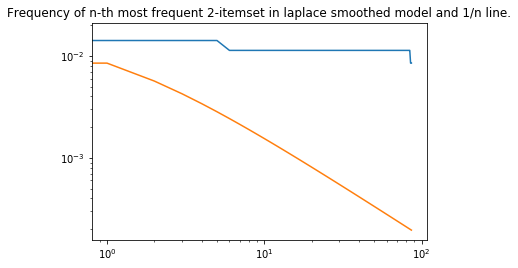

In [105]:
laplacesmoothbimodel = createLeplaceSmoothedBigramModel(tokens, dfforbiperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothbidf = pandas.DataFrame.from_dict(laplacesmoothbimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Bigram Prob. Model : ', len(laplacesmoothbidf.index))
print(laplacesmoothbidf)

#Attempt to plot the bigram language model using first a Counter object
COUNTLapSMOOTH2 = Counter(laplacesmoothbimodel)
greatestlaplacesmoothprob2 = 0
biglaplacesmoothword2 = ''
for w in COUNTLapSMOOTH2.keys():
    if COUNTLapSMOOTH2[w] >= greatestlaplacesmoothprob2:
        biglaplacesmoothword2 = w
        greatestlaplacesmoothprob2 = COUNTLapSMOOTH2[w]
        
print(f"the bigram of greatest freq in the Laplace smoothed bigram model is: {biglaplacesmoothword2} \n")
MLapS2 = COUNTLapSMOOTH2[biglaplacesmoothword2]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 2-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH2.most_common()])
plot([(MLapS2)/i for i in range(1, len(COUNTLapSMOOTH2)+1)]);

In [106]:
#Laplace smoothed trigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedTrigramModel(outset, dfperfilelist):
    n = 3   
    anoutcome = ngrams(outset,3)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            #print(keyword, count[keyword], filecount)
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the trigram probabiities in the Laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    


Number of rows in Laplace Smoothed Trigram Prob. Model :  91
                  prob.
the cat named   0.01105
cat named bob   0.01105
named bob is    0.01105
bob is damn     0.01105
is damn good    0.01105
...                 ...
exist on earth  0.01105
on earth dogs   0.01105
earth dogs are  0.01105
dogs are the    0.01105
are the best    0.01105

[91 rows x 1 columns]
the trigram of greatest freq in the Laplace smoothed trigram model is: do we do 



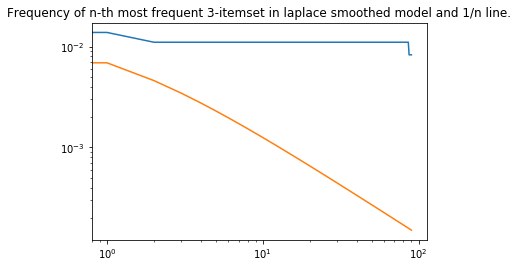

In [107]:
laplacesmoothtrimodel = createLeplaceSmoothedTrigramModel(tokens, dffortriperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothtridf = pandas.DataFrame.from_dict(laplacesmoothtrimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Trigram Prob. Model : ', len(laplacesmoothtridf.index))
print(laplacesmoothtridf)

#Attempt to plot the trigram language model using first a Counter object
COUNTLapSMOOTH3 = Counter(laplacesmoothtrimodel)
greatestlaplacesmoothprob3 = 0
biglaplacesmoothword3 = ''
for w in COUNTLapSMOOTH3.keys():
    if COUNTLapSMOOTH3[w] >= greatestlaplacesmoothprob3:
        biglaplacesmoothword3 = w
        greatestlaplacesmoothprob3 = COUNTLapSMOOTH3[w]
        
print(f"the trigram of greatest freq in the Laplace smoothed trigram model is: {biglaplacesmoothword3} \n")
MLapS3 = COUNTLapSMOOTH3[biglaplacesmoothword3]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 3-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH3.most_common()])
plot([(MLapS3)/i for i in range(1, len(COUNTLapSMOOTH3)+1)]);

In [110]:
#Laplace smoothed trigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedQuadgramModel(outset, dfperfilelist):
    n = 4  
    anoutcome = ngrams(outset,4)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            #print(keyword, count[keyword], filecount)
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the quadgram probabiities in the Laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    


Number of rows in Laplace Smoothed Quadgram Prob. Model :  91
                        prob.
the cat named bob    0.011142
cat named bob is     0.011142
named bob is damn    0.011142
bob is damn good     0.011142
is damn good he      0.011142
...                       ...
not exist on earth   0.011142
exist on earth dogs  0.011142
on earth dogs are    0.011142
earth dogs are the   0.011142
dogs are the best    0.011142

[91 rows x 1 columns]
the quadgram of greatest freq in the Laplace smoothed quadgram model is: what do we do 



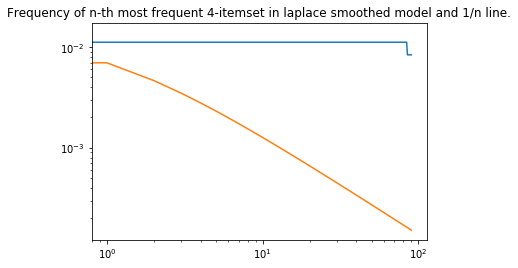

In [111]:
laplacesmoothquadmodel = createLeplaceSmoothedQuadgramModel(tokens, dfforquadperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothquaddf = pandas.DataFrame.from_dict(laplacesmoothquadmodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Quadgram Prob. Model : ', len(laplacesmoothquaddf.index))
print(laplacesmoothquaddf)

#Attempt to plot the quadgram language model using first a Counter object
COUNTLapSMOOTH4 = Counter(laplacesmoothquadmodel)
greatestlaplacesmoothprob4 = 0
biglaplacesmoothword4 = ''
for w in COUNTLapSMOOTH4.keys():
    if COUNTLapSMOOTH4[w] >= greatestlaplacesmoothprob4:
        biglaplacesmoothword4 = w
        greatestlaplacesmoothprob4 = COUNTLapSMOOTH4[w]
        
print(f"the quadgram of greatest freq in the Laplace smoothed quadgram model is: {biglaplacesmoothword4} \n")
MLapS4 = COUNTLapSMOOTH4[biglaplacesmoothword4]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 4-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH4.most_common()])
plot([(MLapS4)/i for i in range(1, len(COUNTLapSMOOTH4)+1)]);